## **Clustering for Dummies: Part 1**

##### Here I'm going to show you the basics of clustering. Reminder: clustering is used to find patterns in data that you *don't* know the labels of. We're going to look at some data from Calcium 45 beta decay. Lots of electrons with varying energies are detected and recorded as waveforms with 3500 time bins. So we don't know beforehand what waveform archetypes will be present in the data set, but we can use a clustering algorithm to find out.

##### The first step in any Python program is to import the packages we will need. Here we import numpy for general math, matplotlib for plotting, KMeans is the prewritten clustering algorithm, and the rest are imports from Noah in order to read the data into a matrix.

##### <span style="color:red">**All of the paths in this code will have to be changed according to where you put the files on your computer.**</span>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import sys; sys.path.insert(0,'C:/Users/Micah/Documents/clustering_for_dummies/ca45_clustering_imports')
import fileread as fr; import wave_ops as wo; import predefined as pd

##### Set the path following "sys.path.insert" (in the above cell) to the folder that I titled "ca45_clustering_imports". You can see how it looks on my machine. If you are on Windows, make sure you replace the "\" characters with the "/" character. To find the path, you can right click on the folder and click "Properties", and it should be listed there.

##### The rest of the paths will be the "clustering_for_dummies" folder

##### The following code will read in the run that we will be using, which is Run_60_0.bin. These functions are written by Noah when he was working on Ca45, since the data format is specific to that experiment. It's not important to understand exactly what's happening here, but the end result is that we convert the data from a binary file to a numpy array.

In [9]:
runs=[run for run in os.listdir('C:/Users/Micah/Documents/clustering_for_dummies')       if run.endswith('.bin') and run[4:-6]!='186']
runs.sort()
print(runs)
path='C:/Users/Micah/Documents/clustering_for_dummies/'
proc_data=fr.gen_output(path+'Run_60-all.dat')[0]

bdch=11#35
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]


mn,mx=0,1460
t=(proc_data.board==bd)*(proc_data.channel==ch)*(proc_data.energy<mx)
proc_data=proc_data[t]

['Run_60_0.bin']


In [17]:
wfs=[]
path='C:/Users/Micah/Documents/clustering_for_dummies/'

for run in runs:
    numwaves=int((os.stat(path+run).st_size-8)/(7033))
    numwaves=20000
    data=fr.raw(path+run,length=3500,numwaves=numwaves,row=1000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data,pretrigger=600)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    data=data[t]
    tot=len(proc_data)
    for i,stamp in enumerate(proc_data.timestamp):
        if divmod(i,100)[1]==0:
            print('\r'+30*' ',end='')
            print('\r'+'{:0d}% of '.format(int(100*i/tot))+run,end='')
        l=np.nonzero(data.timestamp==stamp)[0]
        if l.shape[0]>0:
            wfs.append(data[l[0]])

wfs=np.asarray(wfs).view(np.recarray)

99% of Run_60_0.bin           

##### Now we store all of the data in this variable X. This is a numpy array with dimensions 4250 x 3500. This corresponds to 4250 waveforms, with each one having 3500 time bins. You can double check the number of rows by typing len(X) in a blank cell, and similarly you can double check the number of columns by typing len(X[0,:])

In [18]:
X=wfs.wave[0:len(wfs)].copy().astype('f4')

##### Let's plot a few rows, just to confirm that we are indeed looking at waveforms.

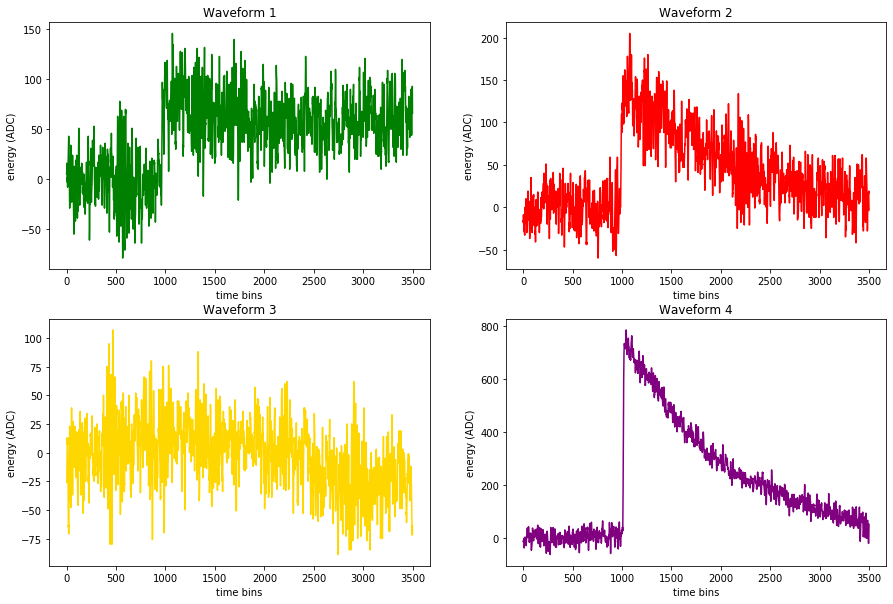

In [68]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))
t = np.arange(3500)
# top left plot
ax[0,0].plot(t, X[0], color = 'g')
ax[0,0].title.set_text("Waveform 1")
ax[0,0].set_xlabel("time bins")
ax[0,0].set_ylabel("energy (ADC)")
# top right plot
ax[0,1].plot(t, X[1], color = 'r')
ax[0,1].title.set_text("Waveform 2")
ax[0,1].set_xlabel("time bins")
ax[0,1].set_ylabel("energy (ADC)")
# bottom left plot
ax[1,0].plot(t, X[2], color = 'gold')
ax[1,0].title.set_text("Waveform 3")
ax[1,0].set_xlabel("time bins")
ax[1,0].set_ylabel("energy (ADC)")
# bottom right plot
ax[1,1].plot(t, X[3], color = 'purple')
ax[1,1].title.set_text("Waveform 4")
ax[1,1].set_xlabel("time bins")
ax[1,1].set_ylabel("energy (ADC)")
plt.show()

##### Now that we believe that the data is correct, let's start with the machine learning part. The first step to any machine learning project is always *pre-processing* the data. We do this to make sure that the data will work well with whichever algorithm we choose to use. For this data, we are going to shrink every waveform to be between -1 and 1 (on y-axis). This removes electron energy dependence from the situation, so that we can focus on finding common waveform shapes.

In [69]:
x_norm = np.zeros_like(X)

##### So I've created an array of zeros in the same shape as our X array. Then we can use this normBatch function to reshape the waveform to be between -1 and 1. The equation for normalizing between -1 and 1 is x' = 2*((x-min(x))/(max(x)-min(x))) - 1. So this function will just loop through the dataset and normalize each waveform.

In [70]:
def normBatch(x):
    for i in range(len(x)):
        x_norm[i] = x[i] - np.amin(x[i])
        x_norm[i] = x_norm[i]*2./np.amax(x[i])
        x_norm[i] = x_norm[i] - 1

In [71]:
normBatch(X)

##### Now we have our pre-processed data stored in the variable x_norm. Let's cluster this data. I'll set it to look for 4 clusters. We set random_state = 0 so that our results are reproducible, and n_jobs = -1 makes sure we use all of the computer's processors for the task (which speeds it up).

In [100]:
kmeans = KMeans(n_clusters = 4, random_state = 0, n_jobs = -1).fit(x_norm)

##### Clustering complete! Let's look at the results

In [107]:
centroids = kmeans.cluster_centers_

##### The cluster centers can be thought of as representative waveforms, or the 'average waveform' from each cluster. We'll plot these now to get an idea of what is contained in each cluster.

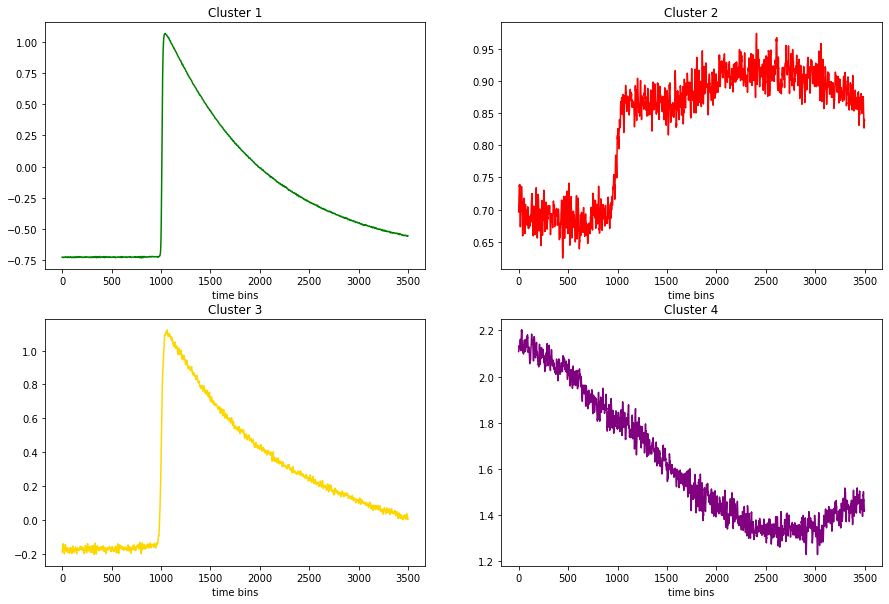

In [110]:
fig, ax = plt.subplots(2, 2, figsize = (15,10))
t = np.arange(3500)
# top left plot
ax[0,0].plot(t, centroids[0], color = 'g')
ax[0,0].title.set_text("Cluster 1")
ax[0,0].set_xlabel("time bins")
# top right plot
ax[0,1].plot(t, centroids[1], color = 'r')
ax[0,1].title.set_text("Cluster 2")
ax[0,1].set_xlabel("time bins")
# bottom left plot
ax[1,0].plot(t, centroids[2], color = 'gold')
ax[1,0].title.set_text("Cluster 3")
ax[1,0].set_xlabel("time bins")
# bottom right plot
ax[1,1].plot(t, centroids[3], color = 'purple')
ax[1,1].title.set_text("Cluster 4")
ax[1,1].set_xlabel("time bins")
plt.show()

##### Let's take the clustering one step further. We want to find the best results possible, without the clusters becoming overly specific (this is what we would call overfitting). So what we'll do is look for an elbow in the graph of inertia vs number of clusters.
##### The inertia is the sum of squared distances from each point to its respective cluster center. A lower value in inertia is better, but we want to choose the elbow of the graph because this will be where the inertia stops decreasing noticeably (or in other words behaves asymptotically). This is to avoid overfitting. 

##### This next step will take multiple minutes for your computer to complete. We are going to cluster the data set many different ways, starting from k=2 and going all the way up to k=29. We will record the inertia each time, and at the end we will be able to make a plot.

In [124]:
inertias = []
for k in range(2,30):
    kmeans = KMeans(n_clusters = k, random_state = 0, n_jobs = -1).fit(x_norm)
    inertias.append(kmeans.inertia_)

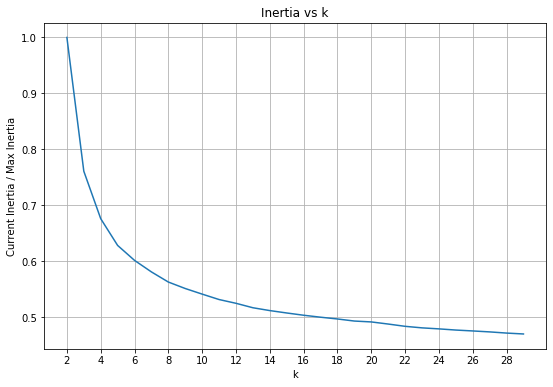

In [219]:
k = np.arange(2,30)
fig, ax = plt.subplots(1,1, figsize = (9,6))
ax.plot(k, inertias/inertias[0])
ax.title.set_text("Inertia vs k")
ax.set_xlabel("k")
ax.set_ylabel("Current Inertia / Max Inertia")
ax.set_xticks(np.arange(2,30,2))
plt.grid()
plt.show()

##### Now we can see the "elbow" in this graph. I'll choose k=8 as a good number of clusters to look at.

In [143]:
kmeans = KMeans(n_clusters = 8, random_state = 0, n_jobs = -1).fit(x_norm)

##### Now to plot the cluster centers. I also do a simple loop to count how many waveforms are in each cluster.

In [157]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
counts = np.zeros(8)
for i in range(8):
    for label in labels:
        if label == i:
            counts[i] += 1

In [199]:
percentage_counts = counts/len(X)
for i in range(len(percentage_counts)):
    percentage_counts[i] = round(percentage_counts[i], 3)

In [183]:
colors = {}
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'

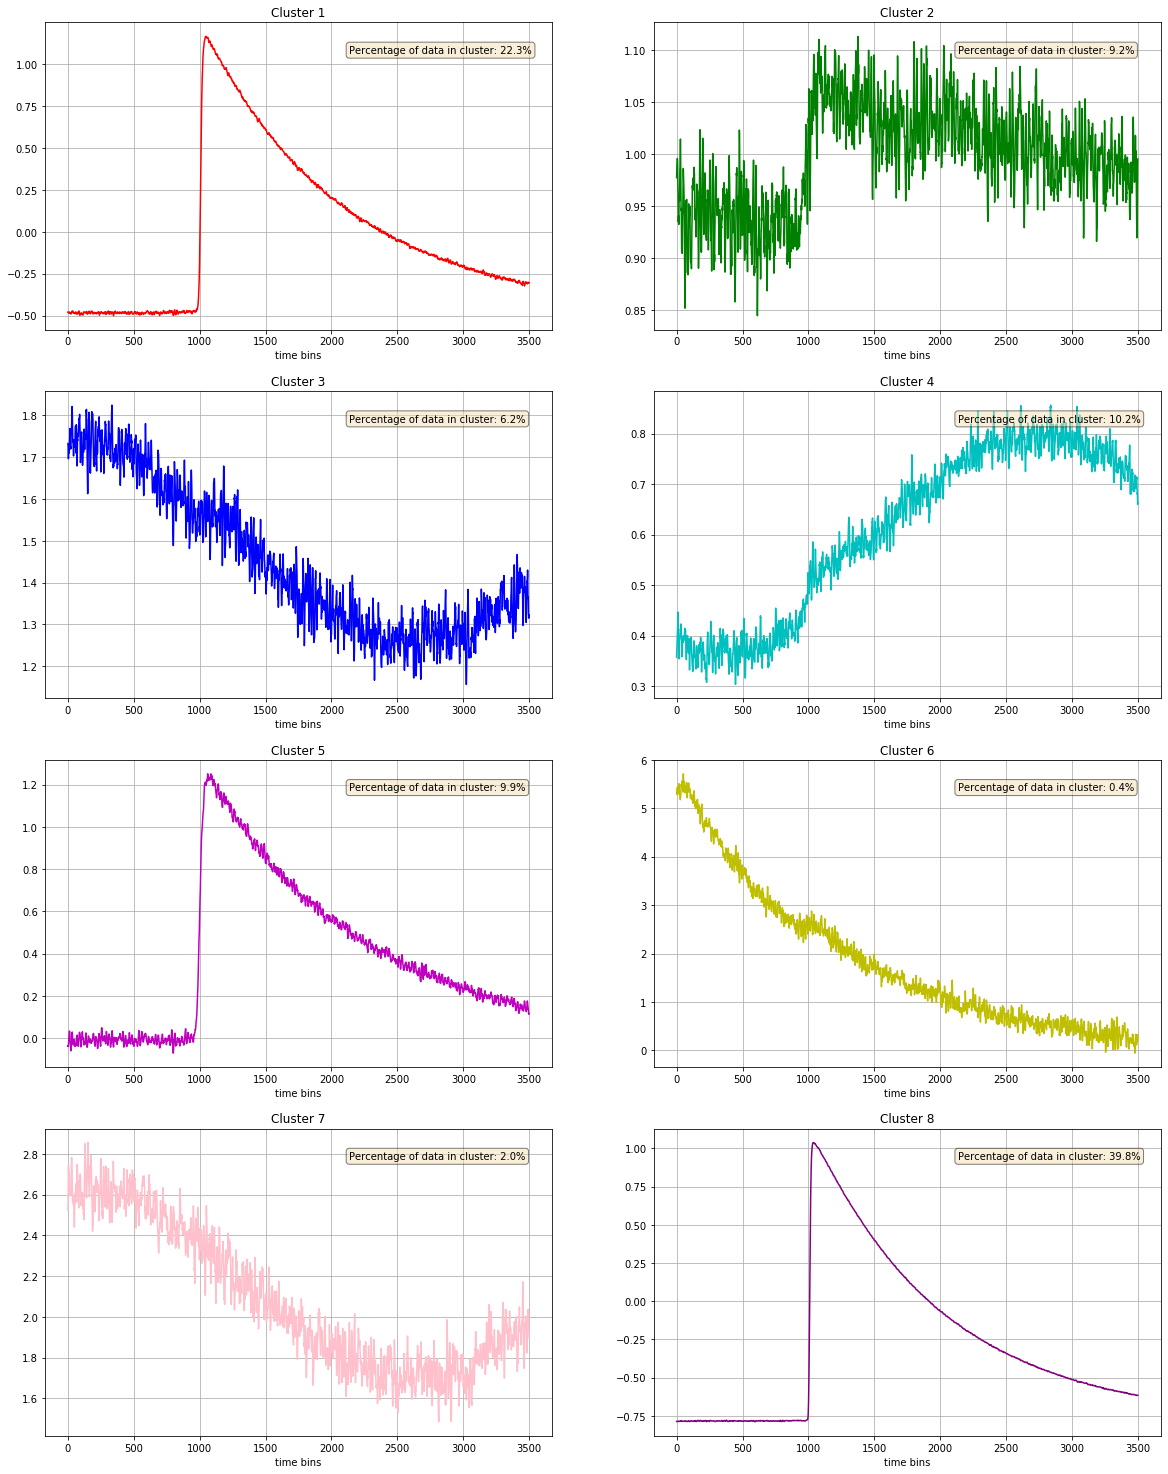

In [234]:
fig, ax = plt.subplots(4, 2, figsize = (20,26))
t = np.arange(3500)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i in range(4):
    for j in range(2):
        k = 2*i+j+1
        ax[i,j].plot(t, centroids[2*i+j], color = colors[k-1])
        ax[i,j].title.set_text("Cluster " + str(k))
        ax[i,j].set_xlabel("time bins")
        ax[i,j].grid()
        text_x = ax[i,j].get_xlim()[1] - 0.4*(ax[i,j].get_xlim()[1] - ax[i,j].get_xlim()[0])
        text_y = ax[i,j].get_ylim()[1] - 0.1*(ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0])
        ax[i,j].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[k-1], 3)) + "%", bbox = props)
plt.show()

##### So now we've looked at representative waveforms for each cluster. But some of these are strange looking. Let's go back to the original waveform data, and use the cluster labels to see the types of actual waveforms present in each cluster. (This may take a bit for your computer to draw)

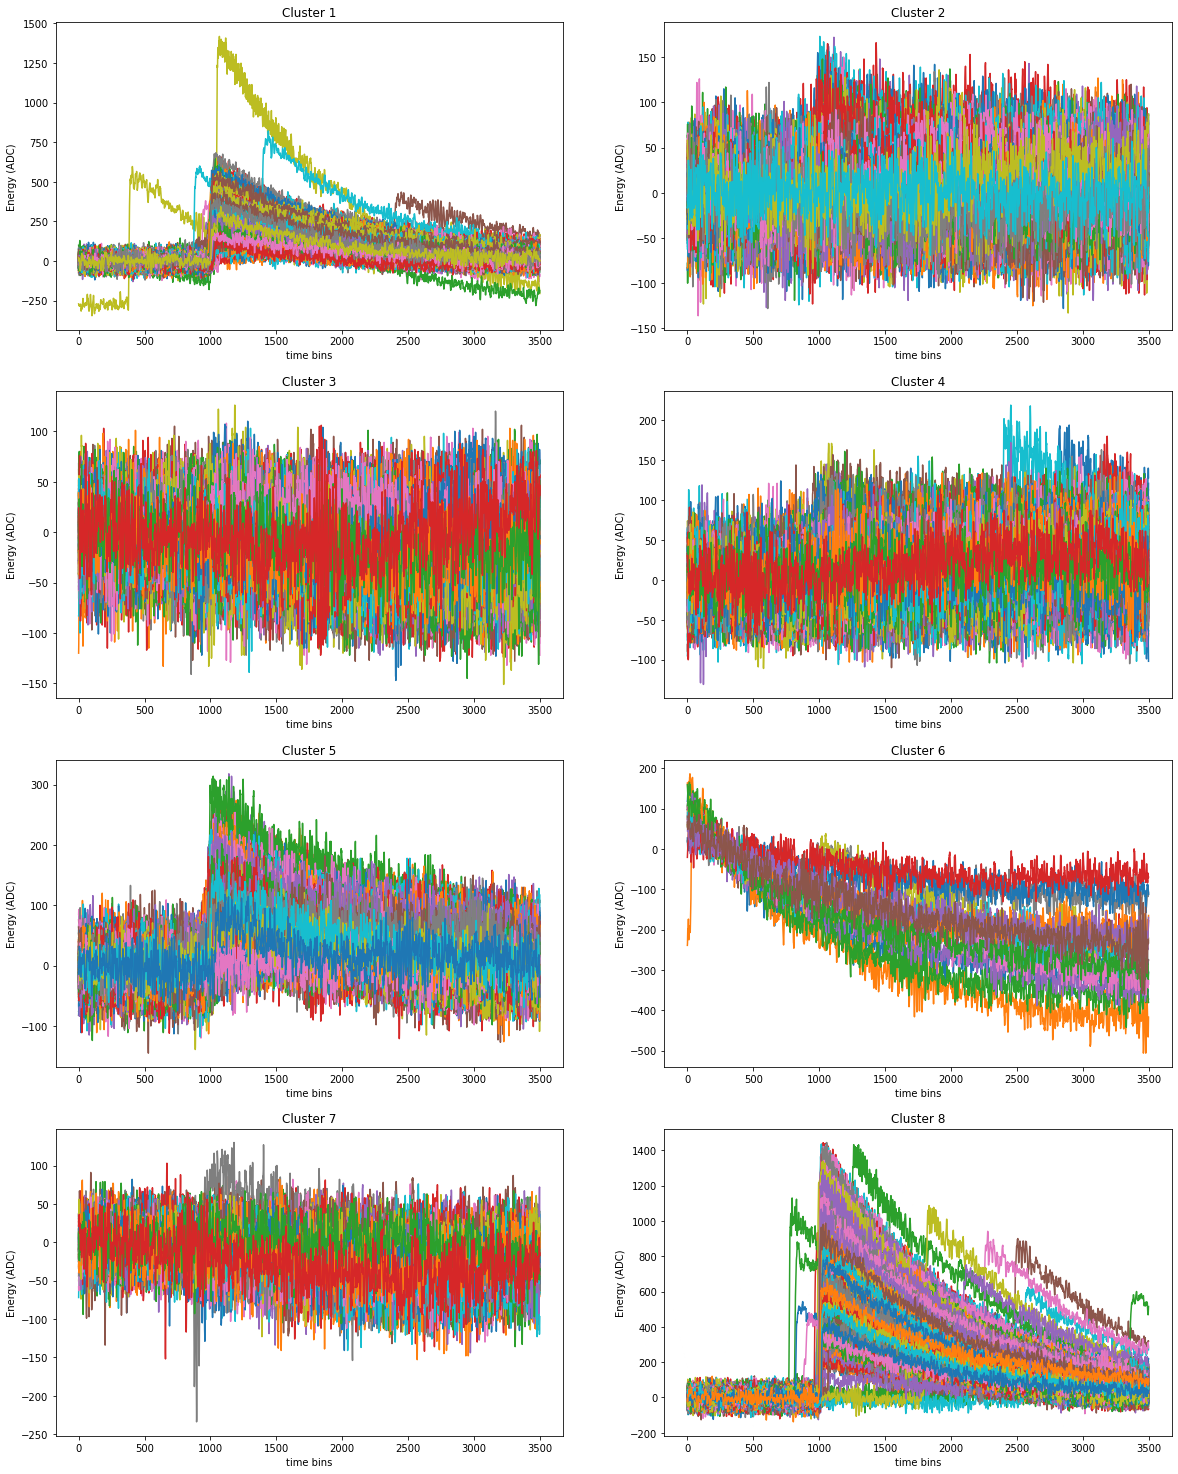

In [237]:
fig, ax = plt.subplots(4, 2, figsize = (20,26))
t = np.arange(3500)
for n in range(len(labels)):
    for i in range(4):
        for j in range(2):
            k = 2*i+j+1
            if k-1 == labels[n]:
                ax[i,j].plot(t, X[n])
                ax[i,j].title.set_text("Cluster " + str(k))
                ax[i,j].set_xlabel("time bins")
                ax[i,j].set_ylabel("Energy (ADC)")
plt.show()

##### And that's it! Next time I'll go through how we can improve the clustering by using dimensionality reduction.